# Read the data from Kaggle and unzip

In [ ]:
# Upload the kaggle.json file (manually)
from google.colab import files
files.upload()

# Make sure the kaggle.json file is in the location ~/.kaggle/kaggle.json to use the API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle datasets download -d nirmalsankalana/rice-leaf-disease-image

In [ ]:
# Create a specific directory to unzip the dataset
!mkdir -p /content/dataset

# Unzip the dataset into the specified directory and preserve the subfolder structure
!unzip rice-leaf-disease-image.zip -d /content/dataset

# Remove the zip file after unzipping to save space
!rm rice-leaf-disease-image.zip

# Import Libraries

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2

import torch
from torchvision import models, transforms

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import LabelEncoder
import shutil


# Create validation images

In [ ]:
# Define the source and destination paths
src_folder = Path('/content/dataset')
dest_folder = Path('/content/val_images')

# Create the destination folder if it doesn't exist
os.makedirs(dest_folder, exist_ok=True)

# Function to move images
def move_images(src, dest, num_images=5):
    # Ensure the destination directory exists
    os.makedirs(dest, exist_ok=True)
    # List all image files in the source directory
    files = [file for file in os.listdir(src) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    # Move the specified number of images
    for file in files[:num_images]:
        shutil.move(src / file, dest / file)

# Iterate over each class directory in the dataset
for class_dir in os.listdir(src_folder):
    class_path = src_folder / class_dir
    if os.path.isdir(class_path):
        move_images(class_path, dest_folder / class_dir)

print("Images have been moved and original images deleted.")

Images have been moved and original images deleted.


# Load data set

In [ ]:
DATA_PATH = Path('/content/dataset')
CLASSES = os.listdir(DATA_PATH) # list of all subdirectory names "classes"
IMG_SIZE = 300
DATA_PATH

PosixPath('/content/dataset')

In [ ]:
print(f'Number of classes: {len(CLASSES)}')
print(CLASSES)

Number of classes: 4
['Blast', 'Bacterialblight', 'Tungro', 'Brownspot']


## Function to read all the images and labels as a list

In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        class_folder = os.path.join(folder, label)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check if the file is an image
                    img_path = os.path.join(class_folder, filename)
                    try:
                        with Image.open(img_path) as img:  # Ensures file is closed after processing
                            img = img.convert('RGB')
                            img_array = np.array(img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS))
                            images.append(img_array)
                            labels.append(label)
                    except IOError:
                        print(f"Error in reading {filename}. Skipping.")
    return np.array(images), labels

In [ ]:
# Load the dataset
images, labels = load_images_from_folder(DATA_PATH)

print(f"Loaded {len(images)} images.")

<ipython-input-5-4a6ef98cd435>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_array = np.array(img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS))


Loaded 5912 images.


## Create Data frame

In [ ]:
# Create DataFrame from the loaded data
data = {'Images': list(images), 'Labels': labels}
df = pd.DataFrame(data)
print(df.head())  # Display the first few rows of the DataFrame

                                              Images Labels
0  [[[41, 59, 19], [44, 62, 22], [49, 67, 25], [5...  Blast
1  [[[48, 58, 47], [47, 58, 44], [44, 56, 42], [4...  Blast
2  [[[46, 32, 31], [49, 35, 34], [48, 34, 33], [4...  Blast
3  [[[175, 150, 203], [175, 151, 203], [174, 150,...  Blast
4  [[[177, 150, 155], [178, 150, 155], [178, 150,...  Blast


In [ ]:
df.to_csv('dataset.csv') #save to csv file

# ML Model

## Feature extraction

In [ ]:
# Feature extraction function
def extract_features(image_data, model, transform):
    image_tensor = transform(image_data)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(image_tensor)
    return features.numpy().flatten()

In [ ]:
# Define transformations and load pre-trained models
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### EfficientNetB0 model

In [ ]:
# Load the pre-trained EfficientNetB0 model
efficientnet_model = models.efficientnet_b0(pretrained=True)
efficientnet_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Extract features using EfficientNetB0
df['EfficientNet_Features'] = df['Images'].apply(lambda x: extract_features(x, efficientnet_model, transform))

### ResNet50

In [ ]:
# Load the pre-trained ResNet50 model
resnet_model = models.resnet50(pretrained=True)
resnet_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Extract features using ResNet50
df['ResNet_Features'] = df['Images'].apply(lambda x: extract_features(x, resnet_model, transform))

### Save extracted features to CSV


In [ ]:
df.to_csv('extracted_features.csv', index=False)

## Classification models

## Pre-proccessing

Split data to train , test

In [ ]:
def prepare_data(df, feature_col):
    X = np.array(df[feature_col].tolist())
    y = df['Labels']

    # Splitting the data into train and test sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    #X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    return X_train, X_test, y_train, y_test


In [ ]:
# Apply the modified function
EX_train, EX_test, Ey_train, Ey_test = prepare_data(df, 'EfficientNet_Features')

In [ ]:
# Apply the modified function
RX_train, RX_test, Ry_train, Ry_test = prepare_data(df, 'ResNet_Features')

## LR

### EfficientNet_B0

In [ ]:
ELR = LogisticRegression(max_iter=10,random_state=42)
ELR.fit(EX_train, Ey_train)

Ey_pred= ELR.predict(EX_test)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("Classification Report on Test Data:\n",classification_report(Ey_test, Ey_pred))
print("Confusion Matrix on Test Data:\n",confusion_matrix(Ey_test, Ey_pred))
print("\nTest Accuracy:",accuracy_score(Ey_test, Ey_pred))

Classification Report on Test Data:
                  precision    recall  f1-score   support

Bacterialblight       0.96      0.97      0.97       316
          Blast       0.89      0.92      0.91       287
      Brownspot       0.96      0.91      0.94       319
         Tungro       0.98      1.00      0.99       261

       accuracy                           0.95      1183
      macro avg       0.95      0.95      0.95      1183
   weighted avg       0.95      0.95      0.95      1183

Confusion Matrix on Test Data:
 [[307   8   1   0]
 [  7 265  10   5]
 [  4  24 291   0]
 [  1   0   0 260]]

Test Accuracy: 0.9492814877430262


### ResNet50

In [ ]:
RLR = LogisticRegression(max_iter=10,random_state=42)
RLR.fit(RX_train, Ry_train)

Ry_pred= RLR.predict(RX_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("Classification Report on Test Data:\n",classification_report(Ry_test, Ry_pred))
print("Confusion Matrix on Test Data:\n",confusion_matrix(Ry_test, Ry_pred))
print("\nTest Accuracy:",accuracy_score(Ry_test, Ry_pred))

Classification Report on Test Data:
                  precision    recall  f1-score   support

Bacterialblight       0.87      0.88      0.88       316
          Blast       0.78      0.77      0.77       287
      Brownspot       0.90      0.89      0.90       319
         Tungro       0.95      0.98      0.96       261

       accuracy                           0.88      1183
      macro avg       0.88      0.88      0.88      1183
   weighted avg       0.88      0.88      0.88      1183

Confusion Matrix on Test Data:
 [[278  34   2   2]
 [ 27 220  28  12]
 [ 12  24 283   0]
 [  2   3   0 256]]

Test Accuracy: 0.8765849535080305


## NN

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

class ComplexModel(nn.Module):
    def __init__(self):
        super(ComplexModel, self).__init__()
        torch.manual_seed(seed)
        np.random.seed(seed)
        self.fc1 = nn.Linear(1000, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [ ]:

# Create an instance of the complex model
modelE = ComplexModel()
modelR = ComplexModel()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizerE = optim.Adam(modelE.parameters(), lr=0.001)
optimizerR = optim.Adam(modelR.parameters(), lr=0.001)



### EfficientNet_B0

In [ ]:
# Convert Ey_train , Ey_test to lists
Ey_train = Ey_train.tolist()
Ey_test = Ey_test.tolist()


# Convert Ey_train ,Ey_test lists to numpy arrays
Ey_train = np.array(Ey_train)
Ey_test = np.array(Ey_test)


In [ ]:
# Create a label encoder instance
label_encoder = LabelEncoder()

# Fit the label encoder on the combined target labels
combined_labels = np.concatenate((Ey_train, Ey_test), axis=0)
label_encoder.fit(combined_labels)

# Convert string labels to numerical labels
Ey_train = label_encoder.transform(Ey_train)
Ey_test = label_encoder.transform(Ey_test)


In [ ]:
Ey_train = Ey_train.astype(np.int64)
Ey_test = Ey_test.astype(np.int64)


In [ ]:
# Convert the input data to PyTorch tensors
X_train = torch.tensor(EX_train).float()
y_train = torch.tensor(Ey_train).long()
X_test = torch.tensor(EX_test).float()
y_test = torch.tensor(Ey_test).long()


In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    modelE.train()
    optimizerE.zero_grad()

    outputs = modelE(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizerE.step()

    # testting
    modelE.eval()
    with torch.no_grad():
        test_outputs = modelE(X_test)
        test_loss = criterion(test_outputs, y_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_accuracy = (test_predicted == y_test).float().mean()

    # Print test loss and accuracy for each epoch
    print(f"Epoch {epoch+1}, test Loss: {test_loss.item():.4f}, test Accuracy: {test_accuracy.item()*100:.2f}%")

Epoch 1, test Loss: 1.0281, test Accuracy: 72.27%
Epoch 2, test Loss: 0.7495, test Accuracy: 78.11%
Epoch 3, test Loss: 0.5483, test Accuracy: 81.74%
Epoch 4, test Loss: 0.4100, test Accuracy: 84.87%
Epoch 5, test Loss: 0.3180, test Accuracy: 87.49%
Epoch 6, test Loss: 0.2583, test Accuracy: 89.01%
Epoch 7, test Loss: 0.2302, test Accuracy: 92.73%
Epoch 8, test Loss: 0.1791, test Accuracy: 93.07%
Epoch 9, test Loss: 0.1464, test Accuracy: 94.93%
Epoch 10, test Loss: 0.1422, test Accuracy: 94.76%


### ResNet50

In [ ]:
# Convert Ry_train , Ry_test to lists
Ry_train = Ry_train.tolist()
Ry_test = Ry_test.tolist()


# Convert Ry_train ,Ry_test lists to numpy arrays
Ry_train = np.array(Ry_train)
Ry_test = np.array(Ry_test)


In [ ]:
# Create a label encoder instance
label_encoder = LabelEncoder()

# Fit the label encoder on the combined target labels
combined_labels = np.concatenate((Ry_train, Ry_test ), axis=0)
label_encoder.fit(combined_labels)

# Convert string labels to numerical labels
Ry_train = label_encoder.transform(Ry_train)
Ry_test = label_encoder.transform(Ry_test)


In [ ]:
Ry_train = Ry_train.astype(np.int64)
Ry_test = Ry_test.astype(np.int64)

In [ ]:
# Convert the input data to PyTorch tensors
X_train = torch.tensor(RX_train).float()
y_train = torch.tensor(Ry_train).long()
X_test = torch.tensor(RX_test).float()
y_test = torch.tensor(Ry_test).long()

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    modelR.train()
    optimizerR.zero_grad()

    outputs = modelR(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizerR.step()

    # testting
    modelR.eval()
    with torch.no_grad():
        test_outputs = modelR(X_test)
        test_loss = criterion(test_outputs, y_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_accuracy = (test_predicted == y_test).float().mean()

    # Print test loss and accuracy for each epoch
    print(f"Epoch {epoch+1}, test Loss: {test_loss.item():.4f}, test Accuracy: {test_accuracy.item()*100:.2f}%")

Epoch 1, test Loss: 0.9384, test Accuracy: 66.27%
Epoch 2, test Loss: 0.9351, test Accuracy: 58.50%
Epoch 3, test Loss: 0.7455, test Accuracy: 69.74%
Epoch 4, test Loss: 0.5824, test Accuracy: 77.94%
Epoch 5, test Loss: 0.5583, test Accuracy: 77.18%
Epoch 6, test Loss: 0.5119, test Accuracy: 78.53%
Epoch 7, test Loss: 0.4146, test Accuracy: 82.84%
Epoch 8, test Loss: 0.3981, test Accuracy: 85.46%
Epoch 9, test Loss: 0.3958, test Accuracy: 84.45%
Epoch 10, test Loss: 0.3281, test Accuracy: 86.90%


# Model deployment

In [ ]:
# For PyTorch:
torch.save(modelE.state_dict(), 'model_weights.pth')
torch.save(efficientnet_model.state_dict(), 'efficientnet_model_weights.pth')

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np

# Load the model
model = ComplexModel()  # Assuming ComplexModel is your NN model class
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

efficientnet_model = models.efficientnet_b0(pretrained=True)
efficientnet_model.load_state_dict(torch.load('efficientnet_model_weights.pth'))
efficientnet_model.eval()

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict(image_path):
    image = Image.open(image_path)
    image = image.convert('RGB')
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        features = efficientnet_model(image_tensor)
        output = model(features)
        prediction = torch.argmax(output, dim=1)
    return prediction.item()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

def get_random_image(path):
    # List all subdirectories in the given path
    subdirectories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

    if not subdirectories:
        raise Exception("No subdirectories found")

    # Randomly select one subdirectory
    selected_subdir = random.choice(subdirectories)
    subdir_path = os.path.join(path, selected_subdir)

    # List all files in the selected subdirectory
    files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]

    if not files:
        raise Exception("No files found in selected subdirectory")

    # Randomly select one file
    selected_file = random.choice(files)
    file_path = os.path.join(subdir_path, selected_file)

    return file_path

# Specify the directory containing the subfolders
directory_path = '/content/val_images'

# Get a random image path
random_image_path = get_random_image(directory_path)
print("Randomly selected image path:", random_image_path)

Randomly selected image path: /content/val_images/Brownspot/BROWNSPOT7_054.jpg


Predicted class: ['Brownspot']


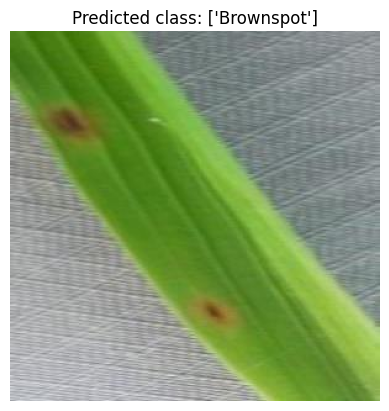

In [ ]:
# Example usage

result = predict(random_image_path)

result = label_encoder.inverse_transform([result])
print(f'Predicted class: {result}')

# Load and display the image using matplotlib
img = Image.open(random_image_path)
img = img.convert('RGB')  # Convert the image to RGB if not already
plt.imshow(img)
plt.title(f'Predicted class: {result}')  # You can display the predicted class as the title
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
